In [344]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
from datasets import load_from_disk
from collections import defaultdict
import torch
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [276]:
dataset = load_from_disk('/datadrive_2/frozen_corpus')

test_data = dataset['test']

In [277]:
test_data = test_data.map(lambda examples: {'sentences': [x.lower() for x in examples['sentences']]}, batched=True)

Loading cached processed dataset at /datadrive_2/frozen_corpus/test/cache-573058092beebe7f.arrow


In [278]:
def pred_data(example):
    return {'st_year_sep': f'[{example["year"]}]' + ' [SEP] ' + example['sentences'] ,
     'year_sep': str(example['year']) + ' [SEP] ' + example['sentences'] ,
     'year_date': str(example['year']) + ' [DATE] ' + example['sentences'] 
        
    }
    
test_data = test_data.map(pred_data , num_proc=6)

#1:   0%|          | 0/96976 [00:00<?, ?ex/s]

#0:   0%|          | 0/96977 [00:00<?, ?ex/s]

#2:   0%|          | 0/96976 [00:00<?, ?ex/s]

#3:   0%|          | 0/96976 [00:00<?, ?ex/s]

#4:   0%|          | 0/96976 [00:00<?, ?ex/s]

#5:   0%|          | 0/96976 [00:00<?, ?ex/s]

In [282]:
test_data = test_data.shuffle(seed=42).select(range(2500))

In [283]:
test_data

Dataset({
    features: ['year', 'nlp', 'pol', 'loc', 'sentences', 'ocr', 'length', 'st_year_sep', 'year_sep', 'year_date'],
    num_rows: 2500
})

In [284]:
test_data[0]

{'year': 1867,
 'nlp': 2194,
 'pol': '[lib]',
 'loc': '[london]',
 'sentences': 'articlesbelonging to his employers. in answer to the pre-sident of the court before which he has just beentried as to what was his motive for committing therobbery, the prisoner said " nothing else butgormandism." in truth, the search of his lodgingswent far to prove the truth of his assertion, for thepolice found there chocolate, sardines, figs, pre-serves, and other good eatables belonging to hismasters, and also a box of excellent cigars, whichwould afford a pleasant smoke after a relish. it wasevident also that the prisoner was delicate in his habitsand did not eat with his fingers, for plenty of forksand',
 'ocr': 0.9695,
 'length': 100,
 'st_year_sep': '[1867] [SEP] articlesbelonging to his employers. in answer to the pre-sident of the court before which he has just beentried as to what was his motive for committing therobbery, the prisoner said " nothing else butgormandism." in truth, the search of 

In [285]:
checkpoints = [#('distilbert','distilbert-base-uncased','[SEP]','year_sep'),
               ('hmd_distilbert','/datadrive_2/bnert-hmd','[SEP]','year_sep'),
               ('bnert-time-st-y','/datadrive_2/bnert-time-st-y','[SEP]','st_year_sep'),
               ('bnert-time-y','/datadrive_2/bnert-time-y','[DATE]','year_date'),
               ('bnert-time-y_masked_25','/datadrive_2/bnert-time-y_masked_25','[DATE]','year_date'),
               ('bnert-time-y_masked_75','/datadrive_2/bnert-time-y_masked_75','[DATE]','year_date')]

model_dict = defaultdict(dict)
for name,checkpoint, st, sent_col in checkpoints:
    model_dict[name]['model'] = AutoModelForMaskedLM.from_pretrained(checkpoint)
    model_dict[name]['tokenizer'] = AutoTokenizer.from_pretrained(checkpoint)
    #model_dict[name]['special_token'] = st
    model_dict[name]['sentences'] = sent_col

Code adapted from this [Stack Overflow](
https://stackoverflow.com/questions/70464428/how-to-calculate-perplexity-of-a-sentence-using-huggingface-masked-language-mode)

In [286]:
def pseudo_perplexity(example, sent_col, name, model, tokenizer):
    tensor_input = tokenizer.encode(example[sent_col], return_tensors='pt',truncation=True, max_length=64)
    #print(tensor_input.shape)
    #if with_meta:
    repeat_input = tensor_input.repeat(tensor_input.size(-1)-4, 1)
    mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[2:-2]
    #else:
    #    repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
    #    mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
    masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
    labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
    with torch.inference_mode():
        loss = model(masked_input, labels=labels).loss
    return {f'loss_{name}':np.exp(loss.item())}

In [287]:
for name, ndict in model_dict.items():
    print(f'Evaluating {name}')
    test_data = test_data.map(pseudo_perplexity, 
                              #num_proc=3,
                              fn_kwargs={'sent_col':ndict['sentences'],
                                        'name': name,
                                        'model':ndict['model'],
                                        'tokenizer':ndict['tokenizer']  
                                   }
                             )

Evaluating hmd_distilbert


  0%|          | 0/2500 [00:00<?, ?ex/s]

Evaluating bnert-time-st-y


  0%|          | 0/2500 [00:00<?, ?ex/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Evaluating bnert-time-y_masked_25


  0%|          | 0/2500 [00:00<?, ?ex/s]

Evaluating bnert-time-y_masked_75


  0%|          | 0/2500 [00:00<?, ?ex/s]

In [288]:
results = test_data.remove_columns(['nlp','loc','length', 'st_year_sep', 'year_sep', 'year_date'])

In [289]:
results_df = results.to_pandas()

In [290]:
results_df.shape

(2500, 9)

In [291]:
results_df['pol'] = results_df.pol.apply(lambda x: x.lstrip('[').rstrip(']'))

In [292]:
results_df[[c for c in results_df.columns if c.startswith('loss')]].sum(axis=0)

loss_hmd_distilbert            82337.838676
loss_bnert-time-st-y           79230.924210
loss_bnert-time-y              78720.447952
loss_bnert-time-y_masked_25    77423.510455
loss_bnert-time-y_masked_75    77552.556247
dtype: float64

In [293]:
#results_df.to_csv('tables/pseudo_perplexity_2500ex_64.csv')

# Inspect results

In [304]:
!ls tables

classsify_pol_regex	  pseudo_perplexity_1000ex_l28.csv  year_pred.csv
classsify_pol_with_regex  pseudo_perplexity_2500ex_64.csv


In [484]:
results_df_128 = pd.read_csv('tables/pseudo_perplexity_1000ex_l28.csv')
results_df_64 = pd.read_csv('tables/pseudo_perplexity_2500ex_64.csv')

In [485]:
from scipy.stats import ttest_ind, ttest_rel
for ch in ['loss_bnert-time-st-y', 'loss_bnert-time-y', 'loss_bnert-time-y_masked_25', 'loss_bnert-time-y_masked_75']:

    print(ch,ttest_rel(results_df_64['loss_hmd_distilbert'],results_df_64[ch], alternative='two-sided').pvalue)

loss_bnert-time-st-y 5.25563047271443e-58
loss_bnert-time-y 1.1377695846624123e-59
loss_bnert-time-y_masked_25 1.8018287277557794e-75
loss_bnert-time-y_masked_75 2.3685196297043552e-70


In [486]:
from scipy.stats import ttest_ind, ttest_rel
for ch in ['loss_bnert-time-st-y', 'loss_bnert-time-y', 'loss_bnert-time-y_masked_25', 'loss_bnert-time-y_masked_75']:

    print(ch,ttest_rel(results_df_128['loss_hmd_distilbert'],results_df_128[ch], alternative='two-sided').pvalue)

loss_bnert-time-st-y 3.1043206608581707e-33
loss_bnert-time-y 1.1046352626321596e-32
loss_bnert-time-y_masked_25 6.3127868900169796e-46
loss_bnert-time-y_masked_75 3.643521000007317e-43


In [487]:
results_df_64['dec'] = results_df_64.year.apply(lambda x: int(str(x)[:3]+'0'))
results_df_128['dec'] = results_df_128.year.apply(lambda x: int(str(x)[:3]+'0'))

In [488]:
scores_64_m = results_df_64[[c for c in results_df_64.columns if c.startswith('loss')]].mean(axis=0) 
scores_64_sd = results_df_64[[c for c in results_df_64.columns if c.startswith('loss')]].std(axis=0) 
scores_128_m = results_df_128[[c for c in results_df_128.columns if c.startswith('loss')]].mean(axis=0) 
scores_128_sd = results_df_128[[c for c in results_df_128.columns if c.startswith('loss')]].std(axis=0) 


In [489]:
print(pd.concat([scores_64_m,scores_64_sd,scores_128_m,scores_128_sd],axis=1).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &      0 &      1 &       2 &       3 \\
\midrule
loss\_hmd\_distilbert         &  32.94 &  64.78 &   25.72 &   45.99 \\
loss\_bnert-time-st-y        &  31.69 &  62.42 &   25.03 &   44.74 \\
loss\_bnert-time-y           &  31.49 &  61.85 &   24.97 &   44.58 \\
loss\_bnert-time-y\_masked\_25 &  30.97 &  61.50 &   24.59 &   44.36 \\
loss\_bnert-time-y\_masked\_75 &  31.02 &  61.41 &   24.63 &   44.40 \\
loss\_distilbert             &    NaN &    NaN &  229.19 &  294.70 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_238407/2314729261.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([scores_64_m,scores_64_sd,scores_128_m,scores_128_sd],axis=1).round(2).to_latex())


In [490]:
#results_df_64

In [491]:

results_df_64 = pd.get_dummies(results_df_64, columns=['pol'])
#results_df_64 = pd.get_dummies(results_df_64, columns=['dec'])


In [492]:
results_df_64

,Unnamed: 0,year,sentences,ocr,loss_hmd_distilbert,loss_bnert-time-st-y,loss_bnert-time-y,loss_bnert-time-y_masked_25,loss_bnert-time-y_masked_75,dec,pol_con,pol_lib,pol_neutr,pol_none,pol_rad
0,0,1867,articlesbelonging to his employers. in answer ...,0.9695,4.898188,4.800630,4.788208,5.310736,5.341368,1860,0,1,0,0,0
1,1,1835,this presump-tion is that the best-informed pe...,0.8501,17.783268,17.446070,17.904489,17.870082,17.897144,1830,1,0,0,0,0
2,2,1855,courts and of the interference of therussian g...,0.9480,8.072949,7.096237,7.065630,6.701583,6.755984,1850,0,1,0,0,0
3,3,1863,french ambassador has been appealed to as toth...,0.9655,8.388589,7.888847,7.970569,8.280886,8.254443,1860,0,1,0,0,0
4,4,1828,"the red barn en the19th april last, in the fro...",0.9184,11.523887,11.071895,10.978597,10.261653,10.176397,1820,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2495,1841,that speech was given toman to enable him to d...,0.9318,8.038355,8.212081,8.155450,7.521363,7.530116,1840,0,1,0,0,0
2496,2496,1838,"liverp.ooi, bououg-11 bank,71111(1) dividendr~...",0.6579,78.923141,77.794717,77.626486,72.519289,73.030444,1830,1,0,0,0,0
2497,2497,1819,"to. do-the sane,rather than,submit to he depti...",0.6601,28.940866,25.827229,24.760396,24.603723,24.499845,1810,0,1,0,0,0
2498,2498,1821,- . i imr. fraser's 'mountebank - - . 2 2three...,0.9231,8.221178,8.351394,8.353206,7.691212,7.642458,1820,0,0,0,1,0


In [499]:
results_df_64['HMDist'] = results_df_64["loss_hmd_distilbert"]

results_df_64['ERWT'] =  results_df_64["loss_bnert-time-y"]
results_df_64['ERWT_ts'] =  results_df_64["loss_bnert-time-st-y"]
results_df_64['ERWT_masked_25'] =  results_df_64["loss_bnert-time-y_masked_25"]
results_df_64['ERWT_masked_75'] = results_df_64["loss_bnert-time-y_masked_75"]

In [500]:
results_dict = {}
for m in ['HMDist','ERWT','ERWT_ts','ERWT_masked_25','ERWT_masked_75']:
    mod = smf.ols(formula=f'{m} ~ ocr + C(dec) + pol_con + pol_lib + pol_neutr + pol_none + pol_rad', data=results_df_64)
    results_dict[m] = mod.fit()
#res.summary()

In [501]:
results_dict['ERWT_masked_25'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ERWT_masked_25   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     100.3
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          5.82e-203
Time:                        16:49:32   Log-Likelihood:                -13351.
No. Observations:                2500   AIC:                         2.673e+04
Df Residuals:                    2487   BIC:                         2.680e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        198.4227      6.533     30.371      0.000     185.612     211.234
C(dec)[T.1810]     6.3610      6.001      1.060      0.289      -5.406      18.128
C(dec)[T.1820]    -6.4619      5.560     -1.162      0.245     -17.365       4.441
C(dec)[T.1830]     7.8886      5.961      1.323      0.186      -3.801      19.578
C(dec)[T.1840]     8.1919      5.453      1.502      0.133      -2.500      18.884
C(dec)[T.1850]    13.0512      5.352      2.438      0.015       2.556      23.547
C(dec)[T.1860]    12.2913      5.508      2.232      0.026       1.491      23.092
C(dec)[T.1870]     2.7508     16.069      0.171      0.864     -28.758      34.260
ocr             -250.5163      8.390    -29.860      0.000    -266.968    -234.065
pol_con           35.5257      3.650      9.734      0.000      28.369      42.682
pol_lib           34.6409      2.556     13.553      0.000      29.629      39.653
pol_neutr         23.9520      5.558      4.310      0.000      13.054      34.850
pol_none          48.4267      3.688     13.132      0.000      41.195      55.658
pol_rad           55.8774      5.125     10.903      0.000      45.828      65.927
==============================================================================
Omnibus:                     2435.444   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           150665.128
Skew:                           4.594   Prob(JB):                         0.00
Kurtosis:                      39.905   Cond. No.                     1.73e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.1e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [502]:
result_params = defaultdict(lambda: defaultdict(dict))
models = ['HMDist','ERWT','ERWT_ts','ERWT_masked_25','ERWT_masked_75']
parameters =  ['ocr','pol_rad','pol_con','pol_lib','C(dec)[T.1820]','C(dec)[T.1860]']
for param in parameters:
    for m in models:
        result_params[param][m]['coef'] = results_dict[m].params[param]
        result_params[param][m]['pvalue'] = results_dict[m].pvalues[param]


In [507]:
print(pd.DataFrame.from_dict({(i,j): result_params[i][j] 
                           for i in result_params.keys() 
                           for j in result_params[i].keys()},
                       orient='index').round(3).to_latex())

\begin{tabular}{llrr}
\toprule
               &                &     coef &  pvalue \\
\midrule
ocr & HMDist & -264.930 &   0.000 \\
               & ERWT & -253.228 &   0.000 \\
               & ERWT\_ts & -255.035 &   0.000 \\
               & ERWT\_masked\_25 & -250.516 &   0.000 \\
               & ERWT\_masked\_75 & -250.432 &   0.000 \\
pol\_rad & HMDist &   60.481 &   0.000 \\
               & ERWT &   56.519 &   0.000 \\
               & ERWT\_ts &   57.072 &   0.000 \\
               & ERWT\_masked\_25 &   55.877 &   0.000 \\
               & ERWT\_masked\_75 &   55.967 &   0.000 \\
pol\_con & HMDist &   37.560 &   0.000 \\
               & ERWT &   36.074 &   0.000 \\
               & ERWT\_ts &   36.397 &   0.000 \\
               & ERWT\_masked\_25 &   35.526 &   0.000 \\
               & ERWT\_masked\_75 &   35.573 &   0.000 \\
pol\_lib & HMDist &   36.718 &   0.000 \\
               & ERWT &   35.115 &   0.000 \\
               & ERWT\_ts &   35.461 &   0.000 \\
         

/tmp/ipykernel_238407/2568293766.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict({(i,j): result_params[i][j]


In [504]:
pd.DataFrame(result_params)

,ocr,pol_rad,pol_con,pol_lib,C(dec)[T.1820],C(dec)[T.1860]
HMDist,"{'coef': -264.9304633814721, 'pvalue': 2.69425...","{'coef': 60.481497010260675, 'pvalue': 1.00640...","{'coef': 37.56034248820701, 'pvalue': 2.333657...","{'coef': 36.718010165844056, 'pvalue': 2.79981...","{'coef': -8.950011068940016, 'pvalue': 0.12468...","{'coef': 10.779858435283511, 'pvalue': 0.06195..."
ERWT,"{'coef': -253.2280442205187, 'pvalue': 7.58729...","{'coef': 56.519271918572514, 'pvalue': 1.77252...","{'coef': 36.07356089334188, 'pvalue': 1.721910...","{'coef': 35.11462232936252, 'pvalue': 3.354089...","{'coef': -6.989408159321629, 'pvalue': 0.21035...","{'coef': 12.087611977577792, 'pvalue': 0.02880..."
ERWT_ts,"{'coef': -255.0354294796855, 'pvalue': 5.51766...","{'coef': 57.07181561660919, 'pvalue': 1.851739...","{'coef': 36.39720693279429, 'pvalue': 1.923284...","{'coef': 35.460952114021865, 'pvalue': 3.52937...","{'coef': -7.462268080375932, 'pvalue': 0.18554...","{'coef': 11.750064543099004, 'pvalue': 0.03539..."
ERWT_masked_25,"{'coef': -250.5162758760136, 'pvalue': 1.07386...","{'coef': 55.877409148982444, 'pvalue': 4.53580...","{'coef': 35.52573370569881, 'pvalue': 5.290524...","{'coef': 34.64087115161699, 'pvalue': 2.009872...","{'coef': -6.461899323798286, 'pvalue': 0.24528...","{'coef': 12.291269024421709, 'pvalue': 0.02573..."
ERWT_masked_75,"{'coef': -250.43203601560785, 'pvalue': 3.0030...","{'coef': 55.96749136824222, 'pvalue': 2.904112...","{'coef': 35.57252590092868, 'pvalue': 3.795387...","{'coef': 34.69364309073651, 'pvalue': 1.044108...","{'coef': -6.602182456272839, 'pvalue': 0.23412...","{'coef': 11.990160385421131, 'pvalue': 0.02921..."


In [505]:
cols = []
for p in parameters:
    cols.extend([f'coef_{p}',f'pvalue_{p}'])

#pd.DataFrame.from_dict(result_params, orient='index',columns=cols)

<AxesSubplot:>

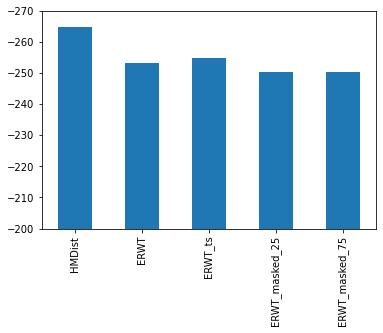

In [414]:
pd.Series(result_params['ocr'], index= models).plot(kind='bar',ylim=(-200,-270))

# Fin.

In [88]:
# def score_random_mask(model, tokenizer, sentence,meta_pos=None):
#     tensor_input = tokenizer.encode(sentence, return_tensors='pt')
#     #print(tensor_input)
#     repeat_input = torch.clone(tensor_input)
#     #print(repeat_input)
#     sum_mask,i = 0,0
#     while sum_mask == 0:
#         mask = torch.tensor(np.random.binomial(1, .15, repeat_input.shape[1]))
#         sum_mask = sum(mask)
        
#     if meta_pos:
#         mask[meta_pos] = 0
#     masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
#     print(masked_input)
#     labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
#     print(labels)
#     with torch.inference_mode():
#         loss = model(masked_input, labels=labels).loss
#     return np.exp(loss.item())

In [ ]:
# from transformers import Trainer

In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=lm_datasets["train"],
#     eval_dataset=lm_datasets["test"],
#     data_collator=data_collator,
# )